<a href="https://colab.research.google.com/github/syedmoiezhussain1996/Notebooks/blob/main/Copy_of_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
df = pd.read_excel('/content/dataset.xlsx')
print(df.shape)

(29924, 3)


In [8]:
df.head(3).T

,0,1,2
Unnamed: 0,0,1,2
MajorCode,marketing,marketing,marketing
MajorCodeDescription,* advertising g/l 7510 *,* sales & marketing *,*02 marketing models


In [9]:
# Create a new dataframe with two columns
df1 = df[['MajorCode', 'MajorCodeDescription']].copy()
# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['MajorCodeDescription'])]
# Renaming second column for a simpler name
#df1.columns = ['MajorCode', 'MajorCodeDescription']


In [10]:
df_balanced=pd.DataFrame()
for category in df1['MajorCode'].unique():
  df_by_majorCode = df1[df1['MajorCode']==category]
  #df_major_downsampled = df_by_majorCode.sample(200)
  df_major_downsampled = df_by_majorCode
  df_balanced = pd.concat([df_balanced, df_major_downsampled])


In [11]:
possible_labels = df_balanced.MajorCode.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

df_balanced['label'] = df_balanced.MajorCode.replace(label_dict)

In [12]:
# Create a new column 'category_id' with encoded categories
df_balanced['label'] = df_balanced['MajorCode'].factorize()[0]
category_id_df = df_balanced[['MajorCode', 'label']].drop_duplicates()
# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['label', 'MajorCode']].values)
# New dataframe
df_balanced.head()
df2=df_balanced

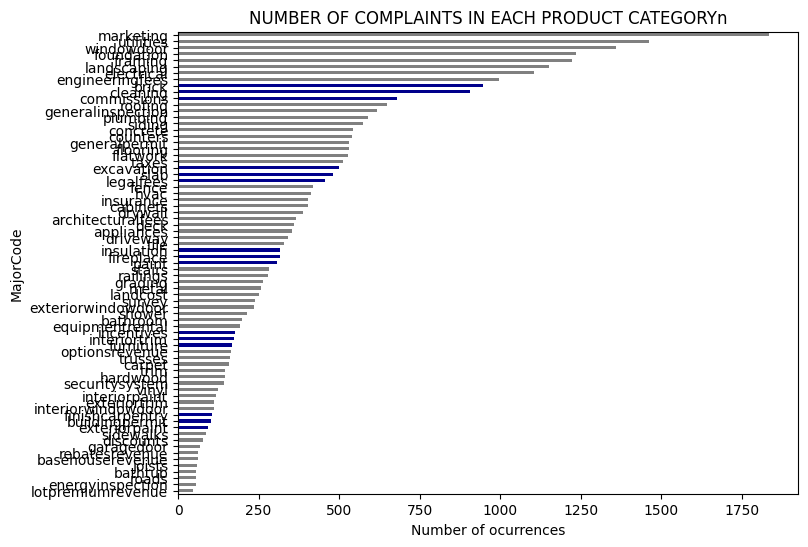

In [13]:
fig = plt.figure(figsize=(8,6))
# df2=df2[df2['MajorCode']=='fireplace']
# print(df2)
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('MajorCode').MajorCodeDescription.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORYn')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [14]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')
# We transform each complaint into a vector
features = tfidf.fit_transform(df2.MajorCodeDescription).toarray()
labels = df2.label
print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 29924 complaints is represented by 3823 features (TF-IDF score of unigrams and bigrams)


In [15]:
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

n==> appliances:
  * Most Correlated Unigrams are: 274, appliance, appliances
  * Most Correlated Bigrams are: 274 02, 274 01, appliances standard
n==> architecturalfees:
  * Most Correlated Unigrams are: architecture, architectural, architect
  * Most Correlated Bigrams are: architect fees, architect design, landscape architect
n==> basehouserevenue:
  * Most Correlated Unigrams are: house, base, revenue
  * Most Correlated Bigrams are: home sales, revenue base, base house
n==> bathroom:
  * Most Correlated Unigrams are: toilet, accessories, bath
  * Most Correlated Bigrams are: shower tub, tub shower, bath accessories
n==> bathtub:
  * Most Correlated Unigrams are: tubs, bathtub, tub
  * Most Correlated Bigrams are: marble tub, tub repairs, tub repair
n==> brick:
  * Most Correlated Unigrams are: brick, stone, masonry
  * Most Correlated Bigrams are: stone labor, brick labor, masonry labor
n==> buildingpermit:
  * Most Correlated Unigrams are: permits, permit, building
  * Most Corre

In [16]:
X = df2['MajorCodeDescription'] # Collection of documents
y = df2['MajorCode'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

In [17]:
# models = [
#     RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
#     LinearSVC(),
#     MultinomialNB(),
#     LogisticRegression(random_state=0),
# ]
# # 5 Cross-validation
# CV = 5
# cv_df = pd.DataFrame(index=range(CV * len(models)))
# entries = []
# for model in models:
#   model_name = model.__class__.__name__
#   accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
#   for fold_idx, accuracy in enumerate(accuracies):
#     entries.append((model_name, fold_idx, accuracy))
# cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


In [18]:
# cv_df

In [19]:
# plt.figure(figsize=(8,5))
# sns.boxplot(x='model_name', y='accuracy',
#             data=cv_df,
#             color='lightblue',
#             showmeans=True)
# plt.title("MEAN ACCURACY (cv = 5)n", size=14);

In [20]:

X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features,
                                                               labels,
                                                               df2.index, test_size=0.25,
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [21]:
# Classification report
print('ttttCLASSIFICATIION METRICSn')
print(metrics.classification_report(y_test, y_pred,
                                    target_names= df2['MajorCode'].unique()))

ttttCLASSIFICATIION METRICSn
                    precision    recall  f1-score   support

         marketing       0.91      0.98      0.94       481
         utilities       0.94      0.95      0.94       390
        windowdoor       0.90      0.92      0.91       333
        foundation       0.91      0.85      0.88       330
           framing       0.93      0.86      0.89       316
       landscaping       0.95      0.94      0.95       283
        electrical       0.92      0.92      0.92       280
   engineeringfees       0.96      0.97      0.96       225
             brick       0.90      0.92      0.91       255
          cleaning       0.94      0.95      0.94       251
       commissions       0.93      0.93      0.93       162
           roofing       0.90      0.93      0.91       156
 generalinspection       0.95      0.94      0.94       171
          plumbing       0.96      0.89      0.92       138
            siding       0.92      0.94      0.93       162
          

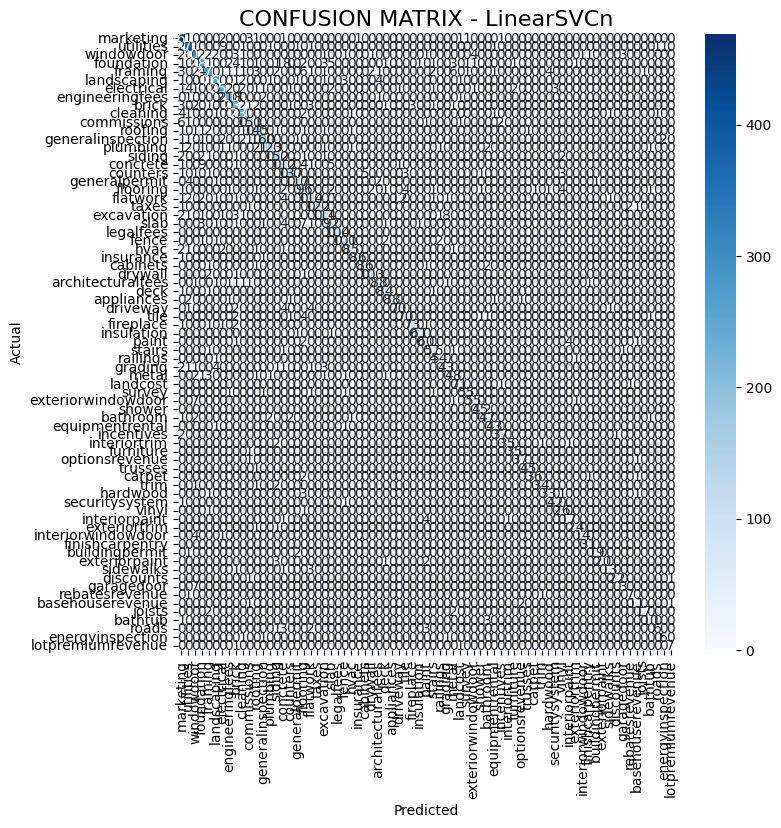

In [22]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.MajorCode.values,
            yticklabels=category_id_df.MajorCode.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVCn", size=16);

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')
fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [32]:
from joblib import dump, load
# Save the trained model to a file
dump(model, '/content/linear_svc_model.joblib')
dump(fitted_vectorizer,'/content/fitted_vectorizer.joblib')

# Later, you can load the model using:
loaded_model = load('/content/linear_svc_model.joblib')
loaded_vectorizer=load('/content/fitted_vectorizer.joblib')

complaint = """Pooled/Lot Specific PAPPA"""
print(model.predict(fitted_vectorizer.transform([complaint])))
print(loaded_vectorizer.transform([complaint]))
print(loaded_model.predict(loaded_vectorizer.transform([complaint])))

['landscaping']
  (0, 2524)	0.6289608179363237
  (0, 1793)	0.6495736322283399
  (0, 1785)	0.4271561609230891
['landscaping']
